### 1. object detection (human & robot)
### 2. robot 2d pose estimation -> 3d pose estimation
### 3. human hand & pose estimation => 3d

In [ ]:
import numpy
import os
os.environ["MASTER_ADDR"]       = "127.0.0.1"
os.environ["MASTER_PORT"]       = "29500"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"
os.environ["MKL_SERVICE_FORCE_INTEL"]  = "1"

In [ ]:
import sys
sys.path.append('/home/NAS/DIP/3d-robot-pose-estimation')

from utils.tools import convert_simple_json_to_yolo, visualize_results


import re
import time
import json
from tqdm import tqdm

from ultralytics import YOLO

import torch

import cv2
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'

In [ ]:
yolo_label_train_path = "/home/najo/NAS/DIP/datasets/meca500/YOLO_train2/labels/train_json" # 360 labels json files
yolo_label_val_path = "/home/najo/NAS/DIP/datasets/meca500/YOLO_train2/labels/val_json" # 40 labels json files

L_train_output_dir = "/home/najo/NAS/DIP/datasets/meca500/YOLO_train2/labels/train"
L_val_output_dir = "/home/najo/NAS/DIP/datasets/meca500/YOLO_train2/labels/val"

image_width = 1920  
image_height = 1080  
class_id = 0    

In [ ]:
# load dataset
label_train_filename = [f for f in os.listdir(yolo_label_train_path) if f.endswith(".json")]
label_val_filename = [f for f in os.listdir(yolo_label_val_path) if f.endswith(".json")]

for i in label_train_filename:
    convert_simple_json_to_yolo(os.path.join(yolo_label_train_path, i), L_train_output_dir, image_width, image_height, class_id)

for i in label_val_filename:
    convert_simple_json_to_yolo(os.path.join(yolo_label_val_path, i), L_val_output_dir, image_width, image_height, class_id)

In [ ]:
model = YOLO("/home/najo/NAS/DIP/datasets/meca500/yolo11x.pt")

model.train(
    val=True,
    data="/home/najo/NAS/DIP/datasets/meca500/YOLO_train2/meca_yolo_train_box.yaml",  # 데이터셋 설정 파일 경로
    epochs=50,                  # 학습 에포크 수
    imgsz=(image_height, image_width),  # 입력 이미지 크기
    rect=True,                # 직사각형 이미지 크기
    batch=6,                   # 배치 크기
    name="custom_yolov11X",       # 실험 이름
    device="0,1,2",
    workers = 16,
)


image 1/1 /home/najo/NAS/DIP/datasets/meca500/image/image268.jpg: 1088x1920 1 Robot, 87.9ms
Speed: 15.9ms preprocess, 87.9ms inference, 191.6ms postprocess per image at shape (1, 3, 1088, 1920)

image 1/1 /home/najo/NAS/DIP/datasets/meca500/image/image268.jpg: 1088x1920 1 Robot, 60.1ms
Speed: 11.6ms preprocess, 60.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)
모델 실행 시간: 0.0898 초
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.7911], device='cuda:0')
data: tensor([[8.4544e+02, 2.5686e+02, 1.1518e+03, 6.6503e+02, 7.9109e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1080, 1920)
shape: torch.Size([1, 6])
xywh: tensor([[998.6031, 460.9443, 306.3323, 408.1746]], device='cuda:0')
xywhn: tensor([[0.5201, 0.4268, 0.1595, 0.3779]], device='cuda:0')
xyxy: tensor([[ 845.4370,  256.8570, 1151.7693,  665.0316]], device='cuda:0')
xyxyn: tensor([[0.4403, 0.2378, 0.5999, 0.6158]], device='c

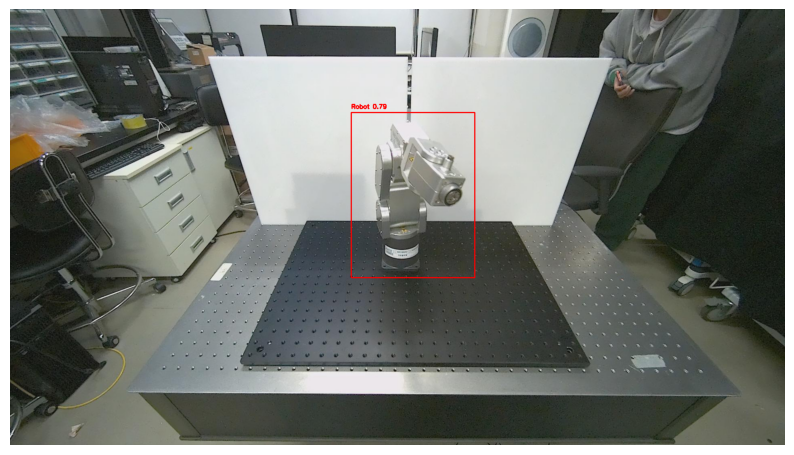

In [7]:
model = YOLO("/home/najo/NAS/DIP/3d-robot-pose-estimation/runs/detect/custom_yolov11X9/weights/360image_train.pt")
example_image_path ="/home/najo/NAS/DIP/datasets/meca500/image/image268.jpg"

import time
_ = model.predict(source=example_image_path, save=False)

start_time = time.time()
results = model.predict(source=example_image_path, save=False)  # save=False로 결과 이미지를 저장하지 않음
end_time = time.time()

execution_time = end_time - start_time  # 총 실행 시간 계산
print(f"모델 실행 시간: {execution_time:.4f} 초")
# print(f'x1, y1, x2, y2 {results[0].boxes.xyxy[0]}')
visualize_results(results, model, example_image_path)

In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_hand_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='/home/najo/NAS/DIP/3d-robot-pose-estimation/models/hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file('/home/najo/NAS/DIP/datasets/ZED/vla_dataset_25G_insertion_cameraMMT/right_camera_output/zed_49429257_right_1744100351.223.jpg')

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_hand_landmarks_on_image(image.numpy_view(), detection_result)

plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()


In [ ]:
import mediapipe as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 1: Set up HandLandmarker
base_options = python.BaseOptions(model_asset_path='/home/najo/NAS/DIP/3d-robot-pose-estimation/models/hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 2: Load the input image.
image = mp.Image.create_from_file('/home/najo/NAS/DIP/datasets/ZED/vla_dataset_25G_insertion_cameraMMT/right_camera_output/zed_49429257_right_1744100351.223.jpg')

# STEP 3: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 4: Get the 3D hand landmarks for visualization
def draw_hand_landmarks_on_image(rgb_image, detection_result):
    hand_landmarks_list = detection_result.hand_landmarks
    annotated_image = np.copy(rgb_image)
    return hand_landmarks_list

hand_landmarks_list = draw_hand_landmarks_on_image(image.numpy_view(), detection_result)

# STEP 5: Extract 3D coordinates and visualize the landmarks and connections
for hand_landmarks in hand_landmarks_list:
    # Extract x, y, z coordinates
    x = [landmark.x for landmark in hand_landmarks]
    y = [landmark.y for landmark in hand_landmarks]
    z = [landmark.z for landmark in hand_landmarks]

    # Set up 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for the hand landmarks
    ax.scatter(x, y, z, c='r', marker='o', label="Hand landmarks")

    # Hand connections: draw lines between connected landmarks
    HAND_CONNECTIONS = [
        (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
        (0, 5), (5, 6), (6, 7), (7, 8),  # Index
        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring
        (0, 17), (17, 18), (18, 19), (19, 20)  # Pinky
    ]
    
    for connection in HAND_CONNECTIONS:
        point1 = connection[0]
        point2 = connection[1]
        ax.plot([x[point1], x[point2]], [y[point1], y[point2]], [z[point1], z[point2]], c='b')  # Draw line between connected points

    # Add labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Hand Landmarks with Connections')

    # Display the plot
    plt.show()


In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='/home/najo/NAS/DIP/3d-robot-pose-estimation/models/pose_landmarker_heavy.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file('/home/najo/NAS/DIP/datasets/meca500/sample_image/cap.png')

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)

plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()

In [ ]:
# # 360개의 이미지로 학습한 모델로 나머지 데이터 추론하기

# model = YOLO("/home/najo/NAS/DIP/3d-robot-pose-estimation/runs/detect/custom_yolov11X9/weights/360image_train.pt")

# image_path = "/home/najo/NAS/DIP/datasets/meca500/image"
# save_path='/home/najo/NAS/DIP/datasets/meca500/image_labels'
# image_filename = [f for f in os.listdir("/home/najo/NAS/DIP/datasets/meca500/image") if f.endswith(".jpg")]


# for i in image_filename:
#     img = cv2.imread(os.path.join(image_path, i))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     results = model.predict(source=img, save=False, verbose=False)
    
#     boxes = results[0].boxes
#     print(boxes)
#     for box in boxes:
#         raw_boxes = results[0].boxes.xyxy.cpu().numpy().astype(int).tolist()
    
#     output_path = os.path.join(save_path, i.replace('.jpg', '.json'))
#     data = {"bounding_boxes": raw_boxes}
#     with open(output_path, 'w') as f:
#         json.dump(data, f, indent=4)


In [ ]:
# # crop the predicted images

# total_image_path = "/home/najo/NAS/DIP/datasets/meca500/image"
# image_with_extension = [f for f in os.listdir(total_image_path) if f.endswith(".jpg")]
# image_with_extension = sorted(image_with_extension, key=lambda x: int(re.search(r'\d+', x).group()))

# for i in tqdm(image_with_extension):
#     results = model.predict(source=os.path.join(total_image_path, i), save=False)
    
#     for result in results:
#         img = cv2.imread(os.path.join(total_image_path, i))

#         for box in result.boxes.xyxy:
#             x_min, y_min, x_max, y_max = map(int, box)
#             cropped_img = img[y_min:y_max, x_min:x_max]
#             cropped_path = os.path.join("/home/najo/NAS/DIP/datasets/meca500/cropped_image", i)
#             cv2.imwrite(cropped_path, cropped_img)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 첫 번째 좌표 세트
points1 = [
    [
        0.0,
        0.0,
        0.152
    ],
    [
        -0.1968463499487935,
        -0.07270062261352693,
        0.521582377804249
    ],
    [
        -0.5612575958070141,
        -0.207287443594233,
        0.593107418946264
    ],
    [
        -0.5259193576203367,
        -0.302970299539599,
        0.593107418946264
    ],
    [
        -0.621602213316709,
        -0.33830853763431634,
        0.5931147774976608
    ],
    [
        -0.6216088492354902,
        -0.3383113932231644,
        0.49311477775860985
    ]
]

# 두 번째 좌표 세트
points2 = [
    [0.0, 0.0, 0.152],
    [0.018237961114570843, -0.02692652330119146, 0.5757538661974587],
    [-0.19920053015294917, 0.2940996355391836, 0.500336972496518],
    [-0.28365200382185896, 0.23689868628876087, 0.500336972496518],
    [-0.34085295259562226, 0.3213501592539308, 0.5003501404305715],
    [-0.3408605066683134, 0.32136063501282836, 0.40035014126459917]
]

# 세 번째 좌표 세트
points3 = [
    [0.0, 0.0, 0.152],
    [0.040781627856600784, 0.013702614917177967, 0.5748168600869615],
    [-0.3332305412547659, -0.11196536346005065, 0.5561766731997313],
    [-0.3007433761599687, -0.20865343978853795, 0.5561766731997313],
    [-0.39743145240412153, -0.24114060485499877, 0.5561809334137003],
    [-0.397435774376135, -0.24114085536121962, 0.45618093350741135]
]

# 네 번째 좌표 세트
points4 = [
    [0.0, 0.0, 0.152],
    [-0.092833555677519, -0.04207777406925395, 0.5645971302246852],
    [-0.45143259431313476, -0.2046165157886466, 0.596423014813942],
    [-0.4093236603478887, -0.2975188175917265, 0.596423014813942],
    [-0.5022259599751469, -0.3396277505707588, 0.5964450904679794],
    [-0.5022459858882131, -0.33963599376172626, 0.49644509281291643]
]

# 3D 포인트로 변환
points1 = np.array(points1)
points2 = np.array(points2)
points3 = np.array(points3)
points4 = np.array(points4)

# 3D 플롯 생성
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# x, y, z 좌표 추출
x1, y1, z1 = points1[:, 0], points1[:, 1], points1[:, 2]
x2, y2, z2 = points2[:, 0], points2[:, 1], points2[:, 2]
x3, y3, z3 = points3[:, 0], points3[:, 1], points3[:, 2]
x4, y4, z4 = points4[:, 0], points4[:, 1], points4[:, 2]

# 3D 산점도
ax.scatter(x1, y1, z1, c='r', marker='o', label="Points Set 1")
ax.scatter(x2, y2, z2, c='b', marker='^', label="Points Set 2")
ax.scatter(x3, y3, z3, c='g', marker='s', label="Points Set 3")
ax.scatter(x4, y4, z4, c='y', marker='d', label="Points Set 4")

# 각 점을 연결하는 선 추가
for i in range(len(points1) - 1):
    ax.plot([x1[i], x1[i+1]], [y1[i], y1[i+1]], [z1[i], z1[i+1]], c='r')
for i in range(len(points2) - 1):
    ax.plot([x2[i], x2[i+1]], [y2[i], y2[i+1]], [z2[i], z2[i+1]], c='b')
for i in range(len(points3) - 1):
    ax.plot([x3[i], x3[i+1]], [y3[i], y3[i+1]], [z3[i], z3[i+1]], c='g')
for i in range(len(points4) - 1):
    ax.plot([x4[i], x4[i+1]], [y4[i], y4[i+1]], [z4[i], z4[i+1]], c='y')

# 각 점에 레이블 추가
for i in range(len(points1)):
    ax.text(x1[i], y1[i], z1[i], f'{i+1}', size=10, color='red')
for i in range(len(points2)):
    ax.text(x2[i], y2[i], z2[i], f'{i+1}', size=10, color='blue')
for i in range(len(points3)):
    ax.text(x3[i], y3[i], z3[i], f'{i+1}', size=10, color='green')
for i in range(len(points4)):
    ax.text(x4[i], y4[i], z4[i], f'{i+1}', size=10, color='yellow')

# 축 라벨
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 그래프 제목
ax.set_title('3D Point Visualization (Four Sets)')

# 범례 추가
ax.legend()

# 그래프 출력
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 1: Set up HandLandmarker
base_options = python.BaseOptions(model_asset_path='/home/najo/NAS/DIP/3d-robot-pose-estimation/models/hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 2: Load the input image.
image = mp.Image.create_from_file('/home/najo/NAS/DIP/datasets/ZED/vla_dataset_25G_insertion_cameraMMT/right_camera_output/zed_49429257_right_1744100351.223.jpg')

# STEP 3: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 4: Get the 3D hand landmarks for visualization
def draw_hand_landmarks_on_image(rgb_image, detection_result):
    hand_landmarks_list = detection_result.hand_landmarks
    annotated_image = np.copy(rgb_image)
    return hand_landmarks_list

hand_landmarks_list = draw_hand_landmarks_on_image(image.numpy_view(), detection_result)

# STEP 5: Extract 3D coordinates and visualize the landmarks and connections
# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# For each hand, extract the landmarks and plot them
for hand_landmarks in hand_landmarks_list:
    # Extract x, y, z coordinates
    x = [landmark.x for landmark in hand_landmarks]
    y = [landmark.y for landmark in hand_landmarks]
    z = [landmark.z for landmark in hand_landmarks]

    # Scatter plot for the hand landmarks (red color for hand)
    ax.scatter(x, y, z, c='r', marker='o', label="Hand landmarks")

    # Hand connections: draw lines between connected landmarks
    HAND_CONNECTIONS = [
        (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
        (0, 5), (5, 6), (6, 7), (7, 8),  # Index
        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring
        (0, 17), (17, 18), (18, 19), (19, 20)  # Pinky
    ]
    
    for connection in HAND_CONNECTIONS:
        point1 = connection[0]
        point2 = connection[1]
        ax.plot([x[point1], x[point2]], [y[point1], y[point2]], [z[point1], z[point2]], c='b')  # Draw line between connected points

# Now add points3 to the same plot
points3 = [
    [0.0 + 1, 0.0, 0.152],
    [0.040781627856600784 + 1, 0.013702614917177967, 0.5748168600869615],
    [-0.3332305412547659 + 1, -0.11196536346005065, 0.5561766731997313],
    [-0.3007433761599687 + 1, -0.20865343978853795, 0.5561766731997313],
    [-0.39743145240412153 + 1, -0.24114060485499877, 0.5561809334137003],
    [-0.397435774376135 + 1, -0.24114085536121962, 0.45618093350741135]
]

# 회전 행렬 (X축 기준으로 90도 회전)
rotation_matrix = np.array([
    [1, 0, 0],   # X축은 변화 없음
    [0, 0, -1],  # Y와 Z축은 뒤집힘
    [0, 1, 0]    # Z축은 Y로 이동
])

# points3를 numpy 배열로 변환
points3 = np.array(points3)

# 회전된 점들을 저장할 리스트
rotated_points = []

# 각 점에 대해 회전 행렬을 곱하기
for point in points3:
    rotated_point = np.dot(rotation_matrix, point)  # 회전 행렬과 점을 곱함
    rotated_points.append(rotated_point)

# 회전된 점 출력
points3 = np.array(rotated_points)

# Extract x, y, z coordinates for points3
x3, y3, z3 = points3[:, 0], points3[:, 1], points3[:, 2]

# Scatter plot for points3 (green color for points3)
ax.scatter(x3, y3, z3, c='g', marker='^', label="Points3")

# Add connections for points3 (if desired, you can create your own set of connections)
for i in range(len(points3) - 1):
    ax.plot([x3[i], x3[i+1]], [y3[i], y3[i+1]], [z3[i], z3[i+1]], c='g')

# Add labels for points3
for i in range(len(points3)):
    ax.text(x3[i], y3[i], z3[i], f'{i+1}', size=10, color='green')

# STEP 6: Calculate the closest distance between points3 and hand landmarks
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Initialize the minimum distance as infinity
min_distance = float('inf')
closest_point3 = None
closest_landmark = None
point3_closest = None
landmark_closest = None

# Find the closest point from points3 to the hand landmarks
for p3 in points3[1:]:
    for hand_landmark in hand_landmarks_list:
        for landmark in hand_landmark:
            p3_array = np.array(p3)
            hand_landmark_array = np.array([landmark.x, landmark.y, landmark.z])
            distance = euclidean_distance(p3_array, hand_landmark_array)
            if distance < min_distance:
                min_distance = distance
                closest_point3 = p3
                closest_landmark = [landmark.x, landmark.y, landmark.z]
                point3_closest = p3
                landmark_closest = [landmark.x, landmark.y, landmark.z]

# STEP 7: Output the closest point and distance
print(f"Closest point from points3: {point3_closest}")
print(f"Closest hand landmark: {landmark_closest}")
print(f"Distance: {min_distance:.4f}")

# STEP 8: Plot a line connecting the closest points
ax.plot([point3_closest[0], landmark_closest[0]], 
        [point3_closest[1], landmark_closest[1]], 
        [point3_closest[2], landmark_closest[2]], 'y-', label="Closest Points Connection")

# Add legend
ax.legend()

view_angles = [
    (30, 30),  # Elevation=30, Azimuth=30
    (90, 90),  # Elevation=90, Azimuth=90
    (45, 90),  # Elevation=45, Azimuth=90
    (0, 90)    # Elevation=0, Azimuth=90
]
elev, azim = view_angles[2]  # Choose the first view angle
ax.view_init(elev=elev, azim=azim)
# Display the plot
plt.show()


In [ ]:
%matplotlib inline



# Display the plot from different angles
for elev, azim in view_angles:
    ax.view_init(elev=elev, azim=azim)
    plt.show()  # Display for each view
